#  Ensemble Spatial Interpolation with Python

This is a tutorial for demonstration of ensemble spatial interpolation in Python with `pyESI` module. 

This exercise demonstrates the ESI estimation methods. The steps include:
1. Import a Dataset with coordinates and a target variable
2. Create a grid ad-hoc to the Dataset as a study area
3. Apply regular sampling to the 2D realization
4. Calculate estimation using ESI with the base interpolation function defined as Inverse Distance Weighting (IDW)
5. Visualize the resulting estimation over the grid

#### Load the required libraries
The following code allows to import the required libraries.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
from matplotlib.pyplot import figure

import seaborn as sns
cmap = plt.cm.jet
from pyESI.ensemble import EnsembleIDW, create_bounds, idw_interpolation

#### Prepare the data
You can download our dataset via [Google Drive](https://drive.google.com/file/d/1VhXKo776gxPJiPZNziCIKCrxkD5PoN_S/view?usp=sharing). The file has GSLIB format.

In [2]:
samples = pd.read_csv("https://drive.google.com/uc?id=1VhXKo776gxPJiPZNziCIKCrxkD5PoN_S", sep='\t', header=None,
        names=['x','y','grade'], index_col=False, usecols=[0,1,3],
        dtype=np.float64, skiprows=6)
samples.head()

,x,y,grade
0,341.0,477.0,0.419
1,141.0,415.0,1.547
2,235.0,207.0,1.138
3,13.0,569.0,0.641
4,19.0,313.0,0.421


In [3]:
nx = 200; ny = 300; cell_size = 2 # grid number of cells and cell size
xmin = 1.0; ymin = 1.0;           # grid origin
xmax = 400; ymax = 600      # calculate the extent of model
vmin = samples["grade"].min(); vmax = samples["grade"].max();

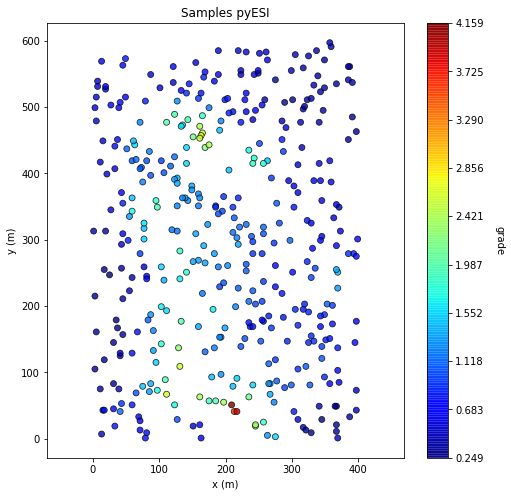

In [4]:
plt.figure(figsize=(8,8))
im = plt.scatter(samples["x"],samples["y"],s=None, c=samples["grade"], marker=None, cmap=plt.cm.jet, norm=None, alpha=0.8, linewidths=0.8, edgecolors="black")
plt.title("Samples pyESI")
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)    
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.axis('equal')
cbar = plt.colorbar(im, orientation = 'vertical', ticks=np.linspace(vmin,vmax,10))
cbar.set_label("grade", rotation=270, labelpad=20)
im

#### Create a Grid
Create a grid of points as an area of study for estimation with ESI methods.

In [5]:
def create_grid_2d(mn, n, siz):
    """
    Creates x, y variables for a 2d grid from gslib
    style parameters, ie, a table in the form
    X   Y 
    ------
    x0  y0
    x1  y0
    ...
    x0  y1
    ...
    xn  yn

    :param mn: Starting values vector (xmn, ymn)
    :param n: Number of points vector (xn, yn)
    :param siz: Vector with block sizes (xsiz, ysiz)
    :return: x and y vectors for the whole grid in GSLIB format (ij, F order)
    """
    # Create range arrays
    x_range = np.linspace(mn[0], int(n[0])*siz[0]+mn[0], num=int(n[0]), endpoint=False)
    y_range = np.linspace(mn[1], int(n[1])*siz[1]+mn[1], num=int(n[1]), endpoint=False)

    # Create a mesh grid (Gslib standard)
    x, y = np.meshgrid(x_range, y_range, indexing="ij")

    # Now create X, Y flatten variables (Fortran order)
    x = x.ravel(order="F")
    y = y.ravel(order="F")

    return x, y

In [6]:
x, y = create_grid_2d([xmin, ymin], [nx, ny], [cell_size, cell_size])
grid = pd.DataFrame({'x':x, 'y':y})

#### Use imported data on a simple example
The following are the basic parameters for this example. This includes the creation of a bounding box in the area covered by the samples and the previously created 2D regular grid.

In [7]:
origin = create_bounds(samples).union(create_bounds(grid))
origin

array([[  1.,   1.],
       [399., 599.]])

We create a *Ensemble Spatial Interpolation* (ESI) with the base interpolation function $\textbf{S}_{\mathcal{L}_k}$  defined as *Inverse Distance Weighting* (IDW). In here, along with the bounding box just configured, we use the samples and the parameters defined as $\alpha = 0.7$ and $m = 20$.

In [8]:
esi = EnsembleIDW(20, 0.7, origin, samples)

The `esi` object is configured and ready to perform an estimation over the grid. 

In [9]:
result = esi.predict(grid)

The `result` esi object has two properties: **estimates** and **variances**. 

In [10]:
array_results = result.estimates.reshape(ny, nx)
array_variance = result.variances.reshape(ny, nx)

Let's visualize the resulting ESI<sub>IDW</sub> estimates with its conditional variance $\mathbb{V}_{\mathcal{Z}_{(\mathcal{P}, \mathcal{M})}}$ for ESI<sub>IDW</sub>. 

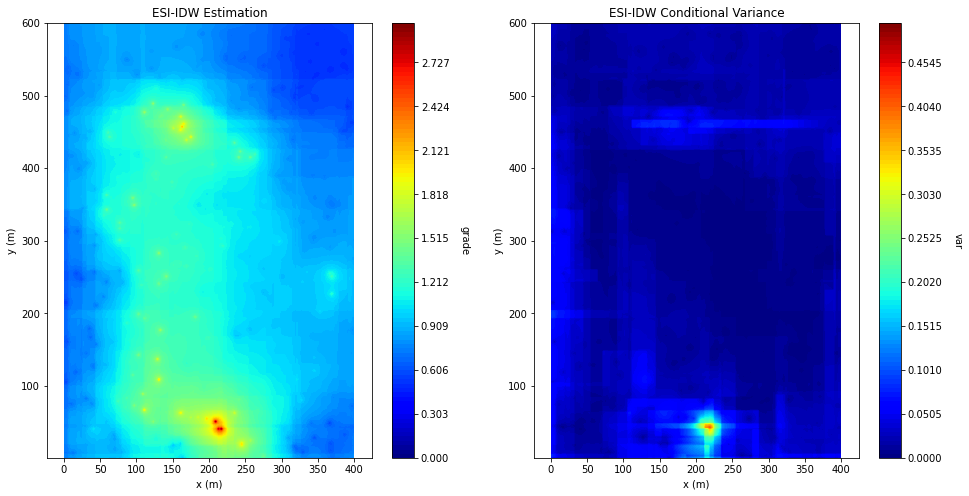

In [11]:
plt.figure(figsize=(16,8))
vmin = 0; vmax = 3;

plt.subplot(121)

cs = plt.contourf(grid.x.values.reshape(ny,nx), grid.y.values.reshape(ny,nx), array_results, cmap=cmap,vmin=vmin, vmax=vmax,levels = np.linspace(vmin,vmax,100))
plt.title("ESI-IDW Estimation")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.axis('equal')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)  
cbar = plt.colorbar(orientation = 'vertical')
cbar.set_label("grade", rotation=270, labelpad=20)

plt.subplot(122)

vmin = 0; vmax = 0.5;
cs = plt.contourf(grid.x.values.reshape(ny,nx), grid.y.values.reshape(ny,nx), array_variance, cmap=cmap,vmin=vmin, vmax=vmax,levels = np.linspace(vmin,vmax,100))
plt.title("ESI-IDW Conditional Variance")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.axis('equal')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)  
cbar = plt.colorbar(orientation = 'vertical')
cbar.set_label("var", rotation=270, labelpad=20)

plt.show()

Let's compare the result with a traditional IDW.

In [12]:
idw = np.zeros_like(result.estimates)
for idp, point in grid.iterrows():
    idw[idp] = idw_interpolation(point.values, samples)

Let's visualize the resulting estimation using IDW.

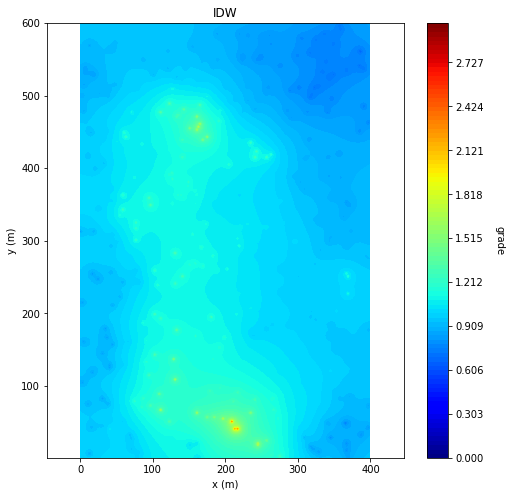

In [13]:
idw_results = idw.reshape(ny, nx)

plt.figure(figsize=(8,8))
vmin = 0; vmax = 3;

cs = plt.contourf(grid.x.values.reshape(ny,nx), grid.y.values.reshape(ny,nx), idw_results, cmap=cmap,vmin=vmin, vmax=vmax,levels = np.linspace(vmin,vmax,100))
plt.title("IDW")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.axis('equal')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)  
cbar = plt.colorbar(orientation = 'vertical')
cbar.set_label("grade", rotation=270, labelpad=20)
plt.show()